Import all Library dependency

In [3]:
import numpy as np
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import os
import cPickle
import matplotlib.pyplot as plt
import numpy as np
import math

Init Bias, Weight, Sparsity Constraint

In [4]:
def init_weights(n_in, n_out, name_weight, xavier_range=4):
    weight = np.asarray(
        np.random.uniform(
            low=-xavier_range * np.sqrt(6. / (n_in + n_out)),
            high=xavier_range * np.sqrt(6. / (n_in + n_out)),
            size=(n_in, n_out)),
        dtype=theano.config.floatX)
    return theano.shared(value=weight, name=name_weight, borrow=True)


def init_bias(n, name_bias):
    return theano.shared(value=np.zeros(n, dtype=theano.config.floatX), name=name_bias, borrow=True)


def init_sparsity_constraint(list_back_neurons, penalty_parameter, sparsity_parameter):


    computation = 0

    for back_neuron in list_back_neurons:

        computation += penalty_parameter * T.shape(back_neuron)[1] * (sparsity_parameter *
        T.log(sparsity_parameter) +
        (1 - sparsity_parameter) * T.log(1 - sparsity_parameter)) \
        - penalty_parameter * sparsity_parameter * T.sum(T.log(T.mean(back_neuron, axis=0) + 1e-6)) \
        - penalty_parameter * (1 - sparsity_parameter) * T.sum(T.log(1 - T.mean(back_neuron, axis=0) + 1e-6))

    return computation


def init_weight_biases_4dimension(filter_shape, d_type):
    fan_in = np.prod(filter_shape[1:])
    fan_out = filter_shape[0] * np.prod(filter_shape[2:])

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[0],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def init_weight_biases_2dimensions(filter_shape, d_type):
    fan_in = filter_shape[1]
    fan_out = filter_shape[0]

    bound = np.sqrt(6. / (fan_in + fan_out))
    w_values = np.asarray(
        np.random.uniform(low=-bound, high=bound, size=filter_shape),
        dtype=d_type)
    b_values = np.zeros((filter_shape[1],), dtype=d_type)
    return theano.shared(w_values, borrow=True), theano.shared(b_values, borrow=True)


def shuffle_data(samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    samples, labels = samples[idx], labels[idx]
    return samples, labels


def sgd_momentum(cost, params, lr=0.05, decay=0.0001, momentum=0.5):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        v = theano.shared(p.get_value())
        v_new = momentum*v - (g + decay*p) * lr
        updates.append([p, p + v_new])
        updates.append([v, v_new])
        return updates

def normalize_image(image):

    min_val = np.min(image)
    max_val = np.max(image)

    return (image-min_val)/(max_val-min_val)

Helper function to load data

In [6]:
class DataCollector:

    def __init__(self, file_path):

        with open(file_path, "rb") as input_file:
            self.data = cPickle.load(input_file)

        self.data_train = self.data[0]
        self.data_test = self.data[2]
        self.data_validate = self.data[1]

    def get_train_data(self):

        return self.data_train[0], self.return_one_hot_encoding(10, self.data_train[1])

    def get_test_data(self):

        return self.data_test[0], self.return_one_hot_encoding(10, self.data_test[1])

    def get_validation_data(self):

        return self.data_validate[0], self.return_one_hot_encoding(10, self.data_validate[1])

    def return_one_hot_encoding(self, num_output, list_data):

        zeros = np.zeros((len(list_data), num_output))

        for i in range(len(zeros)):

            zeros[i][list_data[i]] = 1

        return zeros


Load all the train and test data

In [7]:
data_collector = DataCollector("mnist.pkl")

train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()
validate_x, validate_y = data_collector.get_validation_data()

Data visualization task

In [8]:

class DataVisualization:

    def __init__(self):
       return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name):
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.savefig(figure_name)
        plt.show()


class DataVisualizationWithLabels:

    def __init__(self):
       return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name, labels):

        plt.figure()

        for cnt in range(len(labels)):
           plt.plot(list_x_point[cnt], list_y_point[cnt], label=labels[cnt])

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.savefig(figure_name)
        plt.show()


class DataVisualizationAdjacent:

    def __init__(self):
        return

    def show_plot(self, data, figure_name, number_column=10, limit_image=20, size=28, transpose=True):

        width = height = size

        plt.figure()
        plt.gray()
        row = limit_image/number_column

        for i in range(1, limit_image+1):
            plt.subplot(row, number_column, i)
            plt.axis('off')
            if transpose:
                norm_image = normalize_image(data[:, i-1].reshape(width, height))
            else:
                norm_image = normalize_image(data[i-1].reshape(width, height))
            plt.imshow(norm_image)

        plt.savefig(figure_name)
        print 'Finish Plotting'
        plt.show()


Neural Network of Auto Encoder

In [207]:
class SoftmaxAutoEncoder:

    def __init__(self, num_features, num_outputs, list_hidden_layer, learning_rate,
                 corruption_level=0.01,
                 sparsity_parameter=0.01, penalty_parameter=0.01, momentum=0.1,
                 use_sparsity=False, use_momentum=False, xavier_range=4, shared_weight=True):

        """
        :param list_hidden_layer: [10, 20] -> means 2 hidden layer, 10 neurons ->layer_1, 10 neurons -> layer_2
        :param corruption_level: made the noise in the data
        :param learning_rate: learning rate
        :param sparsity_parameter: 0.1 -> means 0.1 of neurons is activated
        :param penalty_parameter: learning decay
        """

        list_neurons = [num_features] + list_hidden_layer
        x = T.matrix('x')
        d = T.matrix('d')

        self.total_costs_auto_encoder = []
        self.total_costs_full = []
        self.total_predictions_full = []
        self.list_prev_output = []
        self.reconstructed_image = None
        self.hidden_layer_value = []
        self.train_encoder_function = []

        """
            Do the data corruption
        """

        tilde_x = self.corrupt_the_data(corruption_level, x)

        """
            Construct the auto encoder
        """

        self.weights = []
        self.weights_transpose = []
        biases = []
        biases_trans = []

        check_input_train = None
        check_output_train = None

        for ind_neurons in range(2, len(list_neurons)+1):

            """
                ENCODER
            """
            list_trained_neurons = list_neurons[:ind_neurons]
            prev_output = tilde_x
            self.list_prev_output = []

            for i in range(1, len(list_trained_neurons)):

                if i == ind_neurons-1:
                    weight = init_weights(list_trained_neurons[i-1], list_trained_neurons[i], 'weight_%s' % i)
                    bias = init_bias(list_trained_neurons[i], 'bias_%s' % i)

                    self.weights.append(weight)
                    biases.append(bias)
                    check_input_train = prev_output
                    if i == 1:
                        check_input_train = x

                else:
                    # use the previous value, we solely trained the added layer
                    weight = self.weights[i-1]
                    bias = biases[i-1]

                prev_output = T.nnet.sigmoid(T.dot(prev_output, weight) + bias)
                self.list_prev_output.append(prev_output)

            """
                DECODER
            """

            buffer_output = prev_output
            list_back_neurons = []

            for i in range(len(self.weights)-1, -1, -1):

                if i == ind_neurons-2:
                    bias_transpose = init_bias(list_trained_neurons[i], 'bias_trans_%s' % i)
                    biases_trans.append(bias_transpose)
                else:
                    # use the previous bias transpose
                    bias_transpose = biases_trans[i]

                weight_transpose = self.weights[i].transpose()
                
                # instanstiate new weight if not shared weight
                if not shared_weight:
                    
                    if i == ind_neurons-2:
                        eval_size = weights_transpose.eval().shape
                        weight_transpose = init_weights
                        (eval_size[0], eval_size[1], 'weight_%_transpose' % i)
                        self.weights_transpose.append(weight_transpose)
                    else: 
                        weight_transpose = self.weights_transpose[i]

                prev_output = T.nnet.sigmoid(T.dot(prev_output, weight_transpose) + bias_transpose)

                if i == ind_neurons-2:
                    list_back_neurons.append(prev_output)
                    check_output_train = prev_output

            cost = - T.mean(T.sum(check_input_train * T.log(check_output_train) +
                                  (1 - check_input_train) * T.log(1 - check_output_train), axis=1))

            if use_sparsity:
                cost += init_sparsity_constraint(list_back_neurons=list_back_neurons,
                                                 sparsity_parameter=sparsity_parameter,
                                                 penalty_parameter=penalty_parameter)

            params = [self.weights[ind_neurons-2]] + [biases[ind_neurons-2]] + [biases_trans[ind_neurons-2]]
            
            if not shared_weight:
                params += [self.weights_transpose[ind_neurons-2]]
            
            if not use_momentum:
                grads = T.grad(cost, params)
                updates = [(param, param - learning_rate*grad) for param, grad in zip(params, grads)]
            else:
                updates = sgd_momentum(cost, params, momentum=momentum)

            outputs = [cost, prev_output]
            outputs.extend([p_output for p_output in self.list_prev_output])

            train_encoder = theano.function(
                inputs=[x],
                updates=updates,
                outputs=outputs
            )
            self.train_encoder_function.append(train_encoder)

        """
            TRAIN THE FULL CONNECTED LAYER
        """

        last_weight = init_weights(list_neurons[-1], num_outputs, 'last_weight')
        last_bias = init_bias(num_outputs, 'last_bias')

        buffer_output = T.nnet.softmax(T.dot(buffer_output, last_weight) + last_bias)
        y_pred = T.argmax(buffer_output, axis=1)

        cost_cross = T.mean(T.nnet.categorical_crossentropy(buffer_output, d))

        params_full = self.weights + [last_weight] + biases + [last_bias]
        grads_full = T.grad(cost_cross, params_full)
        updates_full = [(param, param - learning_rate * grad) for param, grad in zip(params_full, grads_full)]

        self.train_cross = theano.function(
            inputs=[x, d],
            updates=updates_full,
            outputs=[prev_output, y_pred, cost_cross]
        )

        self.test_cross = theano.function(
            inputs=[x],
            outputs=[y_pred]
        )

    def corrupt_the_data(self, corruption_level, x):

        # use binomial dist at corrupt the data
        rng = np.random.RandomState(123)
        theano_rng = RandomStreams(rng.randint(2 ** 30))

        tilde_x = theano_rng.binomial(size=x.shape, n=1, p=1 - corruption_level,
                                      dtype=theano.config.floatX) * x

        return tilde_x

    def start_train_auto_encoder(self, epochs, batch_size, train_x, train_y, verbose=False):

        print "Start training the auto encoder"
        self.total_costs_auto_encoder = []

        cnt_layer = 1

        for train_encoder in self.train_encoder_function:

            print "Start training layer %s " % cnt_layer
            current_costs_auto_encoder = []

            for epoch in range(epochs):
                # go through training set

                costs = []

                for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):

                    self.hidden_layer_value = []

                    all_value = train_encoder(train_x[start:end])
                    cost, self.reconstructed_image = all_value[:2]

                    for val in all_value[2:]:
                        self.hidden_layer_value.append(val)

                    costs.append(cost)

                current_costs_auto_encoder.append(np.mean(costs, dtype='float64'))

                if verbose:
                    print "Epoch: %d Cost: %s \n" % (epoch, current_costs_auto_encoder[epoch])

            self.total_costs_auto_encoder.append(current_costs_auto_encoder)

            print "Finish training layer %s " % cnt_layer
            cnt_layer += 1

    def start_train_the_full(self, epochs, batch_size, train_x, train_y, test_x, test_y):

        print "Start training the full hidden layer with autoencoder"
        self.total_costs_full = []
        self.total_predictions_full = []

        for epoch in range(epochs):
            # go through trainng set
            costs = []
            results = []

            for start, end in zip(range(0, len(train_x), batch_size), range(batch_size, len(train_y), batch_size)):
                output, result, cost = self.train_cross(train_x[start:end], train_y[start:end])
                costs.append(cost)
                results.append(np.mean(np.argmax(test_y, axis=1) == self.test_cross(test_x)))

            self.total_costs_full.append(np.mean(costs, dtype='float64'))
            self.total_predictions_full.append(np.mean(results, dtype='float64'))
            print "cost: %s, prediction: %s \n" % (self.total_costs_full[epoch], self.total_predictions_full[epoch])

    def get_total_costs_of_auto_encoder(self):

        return self.total_costs_auto_encoder

    def get_total_cost_and_prediction_full(self):

        return self.total_costs_full, self.total_predictions_full

    def get_weights_on_each_layer(self):

        return [weight.get_value() for weight in self.weights]

    def get_reconstructed_image(self):
        
        return self.reconstructed_image

    def get_hidden_layer_activation(self):
        
        return self.hidden_layer_value


This part of assignment aims to provide you with some exposure to the use of autoencoders. Use
the full MNIST dataset for this problem.
Hints: Use corruption level = 0.1, training epochs = up to about 25, learning rate = 0.1, and batch
size = 128 for training of all the layers. 

1) Design a stacked denoising autoencoder consisting of three hidden-layers; 900 neurons in the
first hidden-layer, 625 neurons in the second hidden-layer, and 400 neurons in the third
hidden-layer. To train the network:
- Use the training dataset of MNIST digits
- Corrupt the input data using a binomial distribution at 10% corruption level.
- Use cross-entropy as the cost function

Plot

- a. learning curves for training each layer
- b. Plot 100 samples of weights (as images) learned at each layer
- c. For 100 representative test images plot: 
    - reconstructed images by the network. 
    - Hidden layer activation 

a. Learning curve for training each layer.

Start training the auto encoder
Start training layer 1 
Epoch: 0 Cost: 70.3810550346 

Epoch: 1 Cost: 57.5918183815 

Epoch: 2 Cost: 55.5550864229 

Epoch: 3 Cost: 54.5367515826 

Epoch: 4 Cost: 53.9249307257 

Epoch: 5 Cost: 53.516819683 

Epoch: 6 Cost: 53.2244210155 

Epoch: 7 Cost: 53.0035622176 

Epoch: 8 Cost: 52.8298155056 

Epoch: 9 Cost: 52.6886641161 

Epoch: 10 Cost: 52.5709673855 

Epoch: 11 Cost: 52.4706956937 

Epoch: 12 Cost: 52.3837204349 

Epoch: 13 Cost: 52.3071249451 

Epoch: 14 Cost: 52.2387927964 

Epoch: 15 Cost: 52.1771532501 

Epoch: 16 Cost: 52.1210180788 

Epoch: 17 Cost: 52.0694731067 

Epoch: 18 Cost: 52.021804113 

Epoch: 19 Cost: 51.9774451843 

Epoch: 20 Cost: 51.9359420594 

Epoch: 21 Cost: 51.8969256758 

Epoch: 22 Cost: 51.8600928198 

Epoch: 23 Cost: 51.8251918231 

Epoch: 24 Cost: 51.7920118837 

Epoch: 25 Cost: 51.7603749912 

Epoch: 26 Cost: 51.7301297181 

Epoch: 27 Cost: 51.7011463565 

Epoch: 28 Cost: 51.6733130504 

Epoch: 29 Cost: 51.646532696

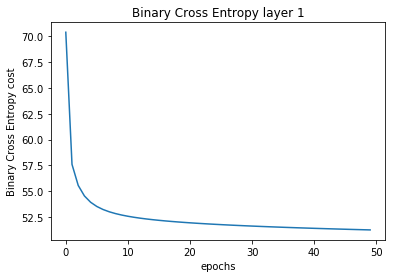

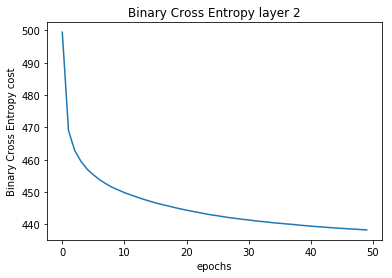

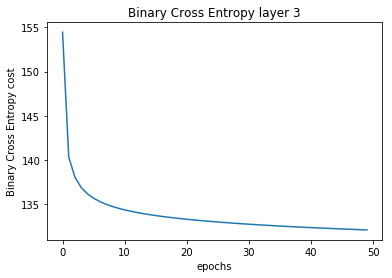

In [192]:
num_feature = len(train_x[0])
list_hidden_layer = [900,625,400]
epochs = 50
batch_size = 128
num_output = 10

softmax = SoftmaxAutoEncoder(num_features=num_feature, num_outputs=num_output,
                             list_hidden_layer=list_hidden_layer, learning_rate=0.1)

softmax.start_train_auto_encoder(epochs=epochs, batch_size=batch_size,
                                 train_x=train_x, train_y=train_y, verbose=True)

list_cost_all_layer = softmax.get_total_costs_of_auto_encoder()

visualizer = DataVisualization()

%matplotlib inline

cntr = 1

for list_cost in list_cost_all_layer:
    visualizer.show_plot(list_x_point=range(epochs),
                         list_y_point=list_cost,
                         x_label='epochs',
                         y_label='Binary Cross Entropy cost',
                         title='Binary Cross Entropy layer %s' % cntr,
                         figure_name='project_b/images/1a_cost_%s.png' % cntr)
    cntr += 1

b. Plot 100 samples of weights (as images) learned at each layer

In [193]:
list_weights = softmax.get_weights_on_each_layer()
hidden_layer_activation = softmax.get_hidden_layer_activation()
number_column = 10
visualizer = DataVisualizationAdjacent()


b.1. plot first layer of auto encoder.

In [ ]:
%matplotlib inline
number_layer = 0
number_column = 10
visualizer.show_plot\
    (
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=28,
     transpose=True
    )

b.2. plot second layer of auto encoder

Finish Plotting


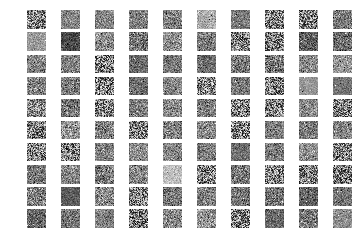

In [195]:
%matplotlib inline
number_layer = 1
number_column = 10
visualizer.show_plot\
    (
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_second.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1])),
     transpose=True
)


b.3. Plot third layer of auto encoder

Finish Plotting


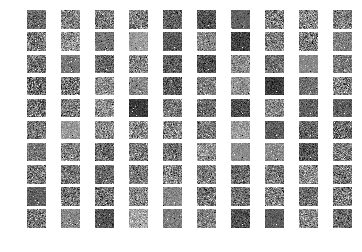

In [196]:
%matplotlib inline
number_layer = 2
number_column = 10
visualizer.show_plot\
    (
     data=list_weights[number_layer], 
     figure_name="project_b/images/1b_auto_third.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1])),
     transpose=True
)


c. For 100 representative test images plot
- reconstructed images by the network.
- Hidden layer activation

### Reconstructed images of the network

In [ ]:
# get the reconstructed images
number_column = 10
reconstructed_images = softmax.get_reconstructed_image()
visualizer.show_plot \
    (
     data=reconstructed_images,
     figure_name="./project_b/images/1c_reconstructed_image.png",
     number_column=number_column,
     limit_image=100,
     size=28,
     transpose=False
    )


### Hidden layer activation

Finish Plotting


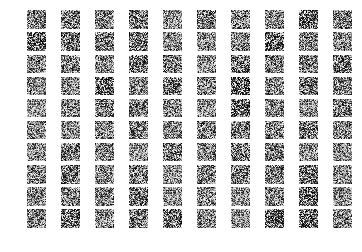

Finish Plotting


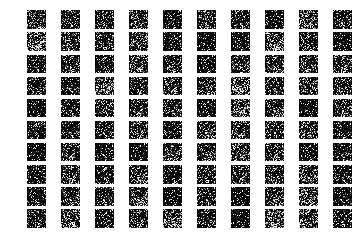

Finish Plotting


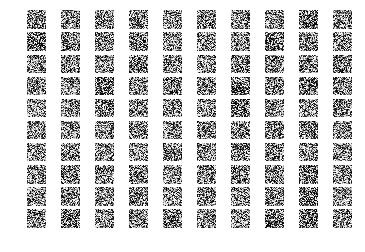

In [197]:
hidden_layer_cnt = 1
for val_hidden_layer in hidden_layer_activation:
    visualizer.show_plot\
        (
         data=val_hidden_layer,
         figure_name="./project_b/images/1c_hidden_layer_%s.png" % hidden_layer_cnt,
         number_column=number_column,
         limit_image=100,
         size=int(math.sqrt(len(val_hidden_layer[0]))),
         transpose=False
        )
    hidden_layer_cnt += 1

2.Train a five-layer feedforward neural network to recognize MNIST data, initialized by the three
hidden layers learned in part (1) and by adding a softmax layer as the output layer. Plot the
training errors and test accuracies during training.

Start training the full hidden layer with autoencoder
cost: 0.558546040155, prediction: 0.837989230769 

cost: 0.275545555224, prediction: 0.922217179487 

cost: 0.227840557076, prediction: 0.935182820513 

cost: 0.199770565904, prediction: 0.941917692308 

cost: 0.179923654213, prediction: 0.946041282051 

cost: 0.164649988856, prediction: 0.949188717949 

cost: 0.152284501076, prediction: 0.951789487179 

cost: 0.141921784782, prediction: 0.954038205128 

cost: 0.133018203759, prediction: 0.95599025641 

cost: 0.125224264126, prediction: 0.957738205128 

cost: 0.11830381536, prediction: 0.959284102564 

cost: 0.11209123428, prediction: 0.960626153846 

cost: 0.106466691421, prediction: 0.961779230769 

cost: 0.101340444957, prediction: 0.962787179487 

cost: 0.0966425228841, prediction: 0.963748974359 

cost: 0.0923164119815, prediction: 0.964583333333 

cost: 0.0883155088329, prediction: 0.965328717949 

cost: 0.0846010110226, prediction: 0.966012820513 

cost: 0.0811404118545, pred

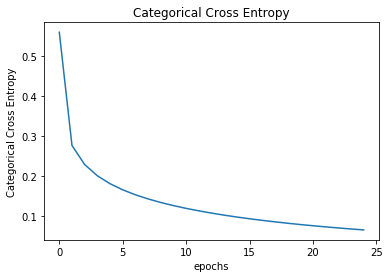

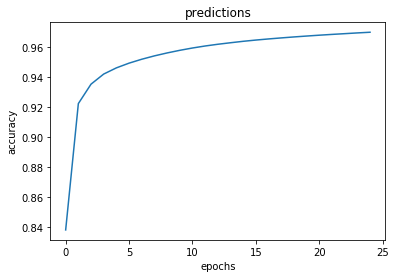

In [30]:
epochs = 25
batch_size = 128

softmax.start_train_the_full(epochs=epochs, batch_size=batch_size,
                             train_x=train_x, train_y=train_y,
                             test_x=test_x, test_y=test_y)  


list_cost, list_prediction = softmax.get_total_cost_and_prediction_full()

visualizer = DataVisualization()

%matplotlib inline

visualizer.show_plot(list_x_point=range(epochs),
                     list_y_point=list_cost,
                     x_label='epochs',
                     y_label='Categorical Cross Entropy',
                     title='Categorical Cross Entropy',
                     figure_name='project_b/images/2_cost.png')


visualizer.show_plot(list_x_point=range(epochs),
                     list_y_point=list_prediction,
                     x_label='epochs',
                     y_label='accuracy',
                     title='predictions',
                     figure_name='project_b/images/2_prediction.png')



3) Repeat part (1) and (2) by introducing the momentum term for gradient descent learning and
the sparsity constraint to the cost function. Choose momentum parameter 𝛾 = 0.1, penalty
parameter 𝛽 = 0.5, and sparsity parameter 𝜌 = 0.05. Compare the results with those of part
(1) and (2)

#### 3.1. Compare result from point 1

Compare result from 1.a

In [198]:
num_feature = len(train_x[0])
list_hidden_layer = [900, 625, 400]
epochs = 50
batch_size = 128
num_output = 10
momentum = 0.1
sparsity_parameter = 0.05
penalty_parameter = 0.5

softmax_momentum_sparsity = SoftmaxAutoEncoder(
    num_features=num_feature, num_outputs=num_output,
    list_hidden_layer=list_hidden_layer, learning_rate=0.1,
    sparsity_parameter=sparsity_parameter, penalty_parameter=penalty_parameter,
    momentum=momentum, use_sparsity=True, use_momentum=True
)

softmax_momentum_sparsity.start_train_auto_encoder(epochs=epochs, batch_size=batch_size,
                                 train_x=train_x, train_y=train_y, verbose=True)


Start training the auto encoder
Start training layer 1 
Epoch: 0 Cost: 115.740208018 

Epoch: 1 Cost: 102.833812009 

Epoch: 2 Cost: 101.177927431 

Epoch: 3 Cost: 100.317939629 

Epoch: 4 Cost: 99.7670108101 

Epoch: 5 Cost: 99.374069378 

Epoch: 6 Cost: 99.0745024062 

Epoch: 7 Cost: 98.83546931 

Epoch: 8 Cost: 98.6383079344 

Epoch: 9 Cost: 98.4715358253 

Epoch: 10 Cost: 98.3276515957 

Epoch: 11 Cost: 98.2015196574 

Epoch: 12 Cost: 98.0894895902 

Epoch: 13 Cost: 97.9888856894 

Epoch: 14 Cost: 97.8976959027 

Epoch: 15 Cost: 97.8143742384 

Epoch: 16 Cost: 97.7377107542 

Epoch: 17 Cost: 97.6667433642 

Epoch: 18 Cost: 97.6006963936 

Epoch: 19 Cost: 97.5389367559 

Epoch: 20 Cost: 97.4809420569 

Epoch: 21 Cost: 97.4262769639 

Epoch: 22 Cost: 97.3745754269 

Epoch: 23 Cost: 97.3255271176 

Epoch: 24 Cost: 97.2788669595 

Epoch: 25 Cost: 97.2343669532 

Epoch: 26 Cost: 97.1918297299 

Epoch: 27 Cost: 97.151083418 

Epoch: 28 Cost: 97.1119775217 

Epoch: 29 Cost: 97.0743795835 

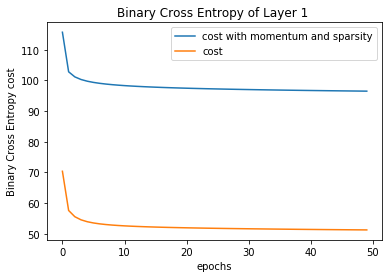

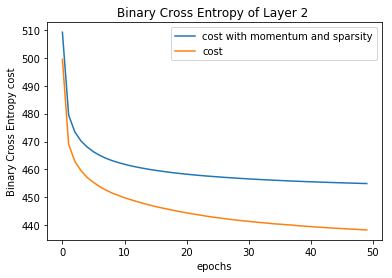

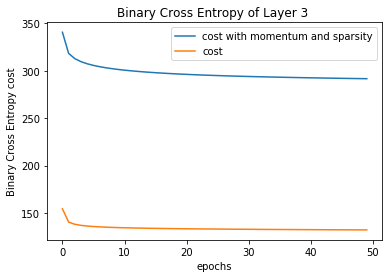

In [199]:
list_cost_momentum_sparsity_all_layer = softmax_momentum_sparsity.get_total_costs_of_auto_encoder()
list_normal_cost_all_layer = softmax.get_total_costs_of_auto_encoder()

visualizer = DataVisualizationWithLabels()

%matplotlib inline
cntr = 1

for list_cost_momentum_sparsity, list_normal_cost in zip(list_cost_momentum_sparsity_all_layer, list_normal_cost_all_layer):    
    visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                         list_y_point=[list_cost_momentum_sparsity, list_normal_cost],
                         x_label='epochs',
                         y_label='Binary Cross Entropy cost',
                         title='Binary Cross Entropy of Layer %s ' % cntr ,
                         figure_name='project_b/images/3a_cost_layer_%s.png' % cntr,
                         labels=['cost with momentum and sparsity', 'cost']  
                        )
    cntr += 1

Compare result from 1.b first layer

In [200]:
list_weights_sparsity_momentum = softmax_momentum_sparsity.get_weights_on_each_layer()
list_weights = softmax.get_weights_on_each_layer() 
hidden_layer_activation_softmax = softmax_momentum_sparsity.get_hidden_layer_activation()
number_column = 10
visualizer = DataVisualizationAdjacent()

Finish Plotting


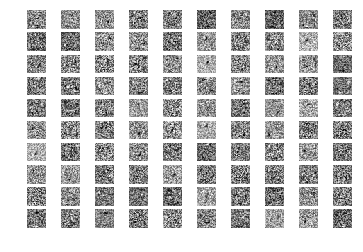

In [201]:
%matplotlib inline
number_layer = 0
visualizer.show_plot\
    (
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_first.png",
     number_column=number_column,
     limit_image=100,
     size=28,
     transpose=True
)


Compare result from 1.b. second layer 

Finish Plotting


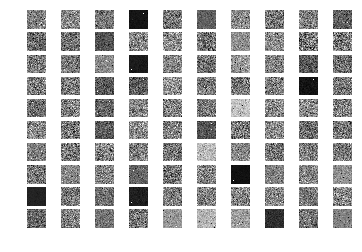

In [202]:
%matplotlib inline
number_layer = 1
visualizer.show_plot\
    (
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_second.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1])),
     transpose=True
)


Compare result from 1.b third layer

Finish Plotting


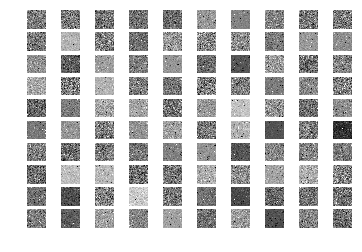

In [203]:
%matplotlib inline
number_layer = 2
visualizer.show_plot\
    (
     data=list_weights_sparsity_momentum[number_layer], 
     figure_name="project_b/images/3b_auto_third.png",
     number_column=number_column,
     limit_image=100,
     size=int(math.sqrt(list_hidden_layer[number_layer-1])),
     transpose=True
    )


Compare result from 1.c 

### Reconstrucred images

Finish Plotting


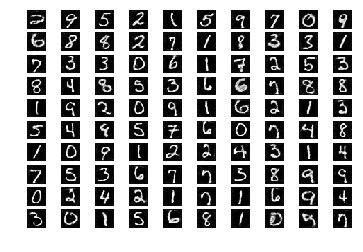

In [204]:
# get the reconstructed images
reconstructed_images = softmax_momentum_sparsity.get_reconstructed_image()
visualizer.show_plot \
    (
     data=reconstructed_images,
     figure_name="./project_b/images/3c_reconstructed_image.png",
     number_column=number_column,
     limit_image=100,
     size=28,
     transpose=False
    )


### Hidden layer activation

Finish Plotting


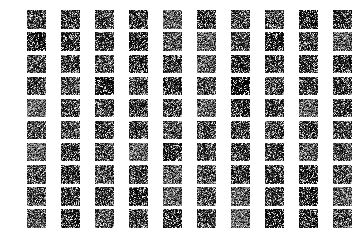

Finish Plotting


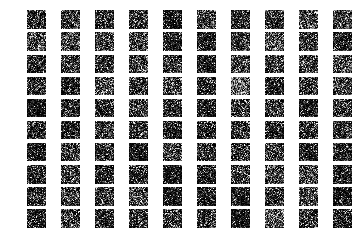

Finish Plotting


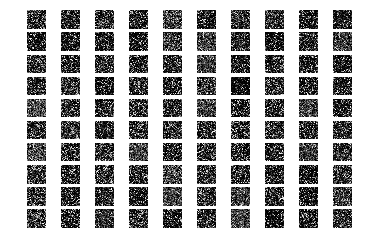

In [ ]:
hidden_layer_cnt = 1

for val_hidden_layer in hidden_layer_activation_softmax:
    visualizer.show_plot\
        (
         data=val_hidden_layer,
         figure_name="./project_b/images/3c_hidden_layer-activation_%s.png" % hidden_layer_cnt,
         number_column=number_column,
         limit_image=100,
         size=int(math.sqrt(len(val_hidden_layer[0]))),
         transpose=False
        )
    hidden_layer_cnt += 1

#### compare result from 2

In [ ]:
epochs = 25

batch_size = 128

softmax_momentum_sparsity.start_train_the_full(epochs=epochs, batch_size=batch_size,
                             train_x=train_x, train_y=train_y,
                             test_x=test_x, test_y=test_y)  


list_cost_spar_mom, list_prediction_spar_mom = softmax_momentum_sparsity.get_total_cost_and_prediction_full()
list_cost, list_prediction = softmax.get_total_cost_and_prediction_full()

visualizer = DataVisualizationWithLabels()

%matplotlib inline

visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                     list_y_point=[list_cost, list_cost_spar_mom],
                     x_label='epochs',
                     y_label='Categorical Cross Entropy',
                     title='Cost result',
                     figure_name='project_b/images/3_cost.png',
                     labels=['normal', 'with sparsity parameter and momentum']
                    )


visualizer.show_plot(list_x_point=[range(epochs) for k in range(2)],
                     list_y_point=[list_prediction, list_prediction_spar_mom],
                     x_label='epochs',
                     y_label='accuracy',
                     title='predictions result',
                     figure_name='project_b/images/3_prediction.png',
                     labels=['normal', 'with sparsity parameter and momentum']
                    )

Start training the full hidden layer with autoencoder
cost: 0.605234269446, prediction: 0.831162820513 

cost: 0.277260725467, prediction: 0.925472051282 

cost: 0.223061378629, prediction: 0.939335384615 

cost: 0.192925206574, prediction: 0.946493589744 

cost: 0.172375608826, prediction: 0.951267948718 

cost: 0.156931046654, prediction: 0.954676153846 

cost: 0.144632141388, prediction: 0.957255128205 

cost: 0.134458973522, prediction: 0.959445384615 

cost: 0.125817568317, prediction: 0.961453076923 

cost: 0.118332512978, prediction: 0.963231282051 

cost: 0.111751226913, prediction: 0.96475 

cost: 0.105895362388, prediction: 0.966023589744 

cost: 0.100634105535, prediction: 0.967168205128 

cost: 0.0958684819664, prediction: 0.96825025641 

cost: 0.0915216442764, prediction: 0.969166666667 



Discussion possible, why use sparsity matrices, why the cost use mean square error -> 2 possible why, use mean all the picxel
or sum error each pattern then get mean of it. 

Sparsity matrices will make the pixel whiter because it makes the hidden value get sparse.